In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns
import warnings

In [ ]:
# Suppress Keras UserWarning
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [ ]:
# Define paths to the dataset and model
dataset_dir = "/content/drive/MyDrive/Tea leaf dataset/Tea leaf dataset"
model_path = "resnet50_tea_leaf_disease_model.keras"

In [ ]:
# Check if dataset directory exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} does not exist.")

In [ ]:
# Moderate image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Load training and validation datasets
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3169 images belonging to 4 classes.
Found 791 images belonging to 4 classes.


In [ ]:
# Check if data is loaded
if train_generator.samples == 0 or validation_generator.samples == 0:
    raise ValueError("No images found in the dataset. Check directory structure.")

In [ ]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

In [ ]:
# Compute class weights to handle dataset imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.43626101321585903, 1: 1.9417892156862746, 2: 1.7644766146993318, 3: 1.5972782258064515}


In [ ]:
# Load the ResNet50 model (pre-trained on ImageNet) without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_resnet50.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 528ms/step - accuracy: 0.2682 - loss: 1.5196 - val_accuracy: 0.7240 - val_loss: 1.2740
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.2812 - loss: 1.4052 - val_accuracy: 0.7357 - val_loss: 1.2808
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 439ms/step - accuracy: 0.3123 - loss: 1.4167 - val_accuracy: 0.6185 - val_loss: 1.2540
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.3438 - loss: 1.4139 - val_accuracy: 0.5846 - val_loss: 1.2575
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - accuracy: 0.3650 - loss: 1.3549 - val_accuracy: 0.6198 - val_loss: 1.1890
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4688 - loss: 1.3815 - val_accuracy: 0.6133 - val_loss: 1.1924
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.4141 - loss: 1.3175 - val_accuracy: 0.6484 - val_loss: 1.1632
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5000 - loss: 1.2973 - val_accuracy: 

In [ ]:
# Fine-tuning: Unfreeze some layers
num_layers = len(base_model.layers)
fine_tune_at = int(num_layers * 0.9)  # Unfreeze last 10% of layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [ ]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 524ms/step - accuracy: 0.6320 - loss: 2.3188 - val_accuracy: 0.6680 - val_loss: 1.2403
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6250 - loss: 0.7545 - val_accuracy: 0.6706 - val_loss: 1.2364
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - accuracy: 0.7012 - loss: 0.7718 - val_accuracy: 0.7018 - val_loss: 1.1554
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6875 - loss: 0.8326 - val_accuracy: 0.7096 - val_loss: 1.1472
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 771ms/step - accuracy: 0.7278 - loss: 0.7214 - val_accuracy: 0.7214 - val_loss: 0.8394
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7188 - loss: 0.4850 - val_accuracy: 0.7253 - val_loss: 0.8474
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 102s 447ms/step - accuracy: 0.7910 - loss: 0.6127 - val_accuracy: 0.8099 - val_loss: 0.5266
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8438 - loss: 0.5938 - val_accuracy: 0

In [ ]:
# Plot training and validation accuracy/loss
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

Initial Training Results:


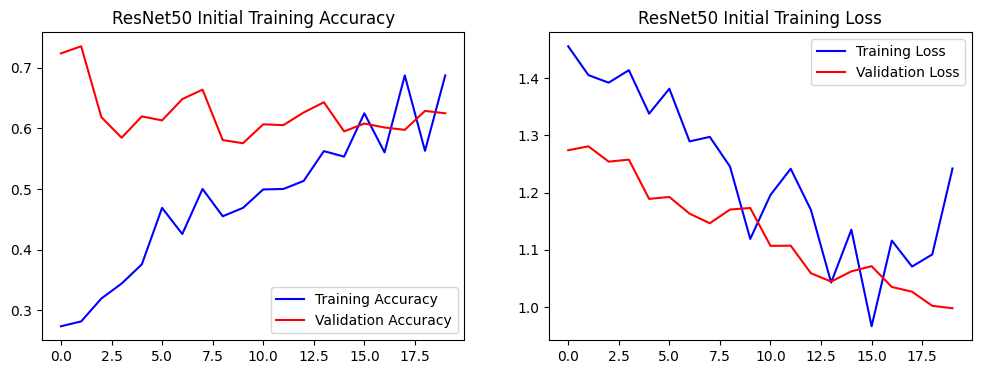

Fine-Tuning Results:


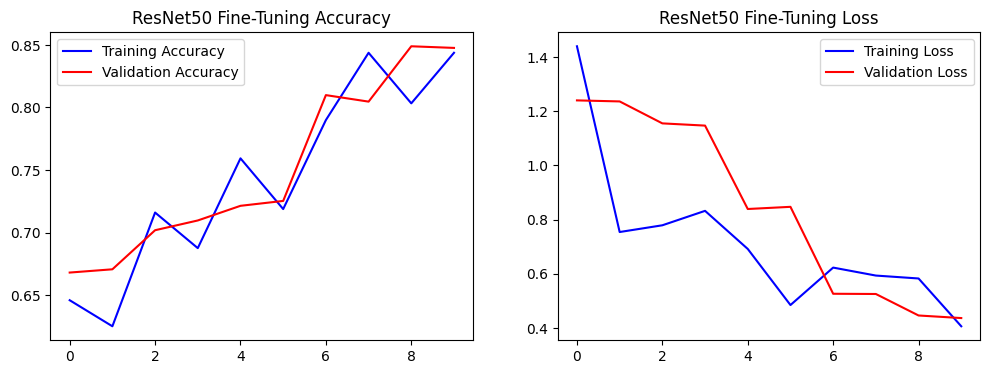

In [ ]:
# Plot the results
print("Initial Training Results:")
plot_training_history(history, "ResNet50 Initial Training")
print("Fine-Tuning Results:")
plot_training_history(history_finetune, "ResNet50 Fine-Tuning")

In [ ]:
# Evaluate the model on the validation set
validation_generator.reset()
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.8856 - loss: 0.3703
Test Accuracy: 84.58%
Test Loss: 0.4531


In [ ]:
# Generate confusion matrix and classification report
def evaluate_model(model, validation_generator):
    validation_generator.reset()
    y_true = []
    y_pred = []
    steps = np.ceil(validation_generator.samples / validation_generator.batch_size).astype(int)

    for i in range(steps):
        images, labels = next(validation_generator)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))

    class_labels = list(validation_generator.class_indices.keys())
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred, target_names=class_labels))

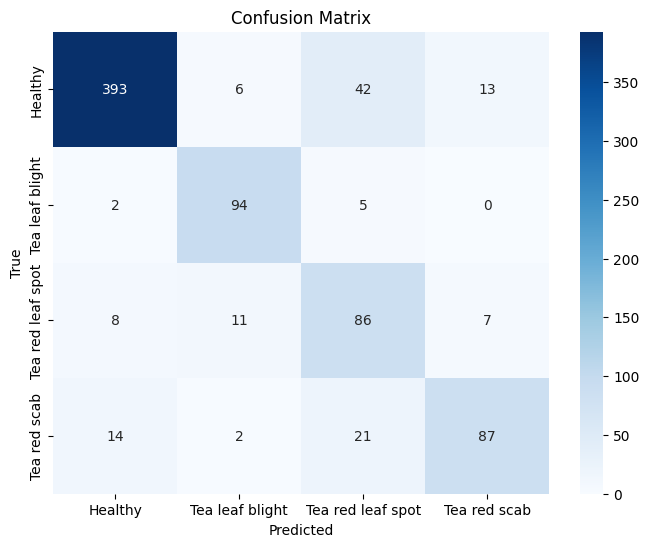

                   precision    recall  f1-score   support

          Healthy       0.94      0.87      0.90       454
  Tea leaf blight       0.83      0.93      0.88       101
Tea red leaf spot       0.56      0.77      0.65       112
     Tea red scab       0.81      0.70      0.75       124

         accuracy                           0.83       791
        macro avg       0.79      0.82      0.80       791
     weighted avg       0.85      0.83      0.84       791



In [ ]:
# Evaluate the model
evaluate_model(model, validation_generator)

In [ ]:
# Save the final model
model.save(model_path)
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Prediction phase
print("\nGenerating Predictions for a Batch of Validation Images:")
validation_generator.reset()
model = load_model(model_path)
print("Model loaded for predictions!")

In [ ]:
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
print("Class labels:", class_labels)

In [ ]:
# Function to display predictions and images
def show_predictions(model, generator, num_images=8):
    generator.reset()
    images, true_labels = next(generator)
    predictions = model.predict(images, verbose=0)
    true_classes = np.argmax(true_labels, axis=1)
    pred_classes = np.argmax(predictions, axis=1)
    pred_probabilities = np.max(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[true_classes[i]]
        pred_label = class_labels[pred_classes[i]]
        confidence = pred_probabilities[i] * 100
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%"
        plt.title(title, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nDetailed Predictions for the Batch:")
    for i in range(len(images)):
        true_label = class_labels[true_classes[i]]
        pred_label = class_labels[pred_classes[i]]
        confidence = pred_probabilities[i] * 100
        print(f"Image {i+1}: True Label: {true_label}, Predicted Label: {pred_label}, Confidence: {confidence:.2f}%")

In [ ]:
# Show predictions for a batch of 8 images
show_predictions(model, validation_generator, num_images=8)